### Assignment 5 - Machine Learning, FSA
### By: Sourita Nag


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score,roc_curve

### Question 1a: Gisette Dataset

In [2]:
#Importing the dataset
#Importing the dataset
data_train = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Gisette/gisette_train.data')
data_train
data_train_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Gisette/gisette_train_labels.labels')
data_test = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Gisette/gisette_valid.data')
data_test_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Gisette/gisette_valid_labels.labels')
data_train.shape,data_train_labels.shape,data_test.shape,data_test_labels.shape
#No Null data present at this stage

((6000, 5000), (6000,), (1000, 5000), (1000,))

In [3]:
data_test_labels = data_test_labels.reshape(-1,1)
data_train_labels = data_train_labels.reshape(-1,1)
data_train_labels.shape,data_test_labels.shape

((6000, 1), (1000, 1))

In [4]:
#Training data
data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)

means = np.array(np.mean(data_train))
means = means.reshape(1,data_train.shape[1])
stds = np.array(data_train.std())
stds = stds.reshape(1,data_train.shape[1])

data_train = (data_train - means)/stds
data_test = (data_test - means)/stds
data_test = pd.DataFrame(data_test)

cols1 = data_train.columns[data_train.isnull().any()].tolist()
cols1

cols2 = data_test.columns[data_test.isnull().any()].tolist()
cols1 == cols2

data_train = data_train.drop(columns = cols1)
data_test = data_test.drop(columns = cols2)
data_train.shape,data_test.shape

((6000, 4955), (1000, 4955))

In [5]:
X_train = np.array(data_train)
Y_labels_train = np.array(data_train_labels)
X_test = np.array(data_test)
Y_labels_test = np.array(data_test_labels)
X_ones_train =np.ones((X_train.shape[0], 1))
X_train = np.hstack((X_ones_train, X_train))
print(X_train.shape)
X_ones_test = np.ones((X_test.shape[0],1))
X_test = np.hstack((X_ones_test,X_test))
print(X_test.shape)

(6000, 4956)
(1000, 4956)


In [6]:
X_traint = X_train
X_testt = X_test

In [7]:
def lorenz_loss(x):
    v = np.where(x>1,0,np.log(1+(x-1)**2))
    return v

In [8]:
def FSA(k, X_train, X_test,eta):
    Niter = 300
    p_ini = (X_train.shape[1])
    #k = 30
    mu = 300
    #eta = 0.001
    s = 0.001
    beta = np.zeros((X_train.shape[1],1))
    #beta_idx = np.arange(X_train.shape[1])
    N = X_train.shape[0]
    loss = []
    for itr in range(Niter):
        gradient = 0
        for i in range(N):
            score = data_train_labels[i]@beta.T@X_train[i,:].reshape(-1,1)
            if score > 1:
                gradient += 0
            else:
                gradient += ((2*((data_train_labels[i]@beta.T@X_train[i,:].reshape(-1,1)) - 1)*(data_train_labels[i]*X_train[i,:].reshape(-1,1)))/ (1 + (data_train_labels[i]@beta.T@X_train[i,:].reshape(-1,1) - 1)**2))
        gradient = gradient/N + 2*s*beta
        beta = beta - eta*gradient
        beta_idx = np.arange(np.shape(beta)[0])
        beta_sq = np.abs(beta**2)
        beta_sq_idx = np.argsort(beta_sq,axis = 0)[::-1]
        Mi = k + (p_ini-k)*(max(0,(Niter - 2*itr)/(2*itr*mu + Niter)))
        Mi = int(Mi)
        beta1 = beta[beta_sq_idx]
        beta_upd = beta1[:Mi]
        beta_upd = beta_upd.reshape(beta_upd.shape[0],1)
        cols_train = beta_sq_idx[:Mi]
        beta_idx = beta_idx[cols_train]
        X_train = X_train[:,cols_train]
        X_test = X_test[:,cols_train]
        X_train = X_train.reshape(N,X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
#         new_col_order = [val for val in range(Mi)]
#         X_train = X_train[:,new_col_order]
#         X_test = X_test[:,new_col_order]
#         X_train = X_train.reshape(N,X_train.shape[1])
#         X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
        score = []
        for i in range(X_train.shape[0]):
            sc = data_train_labels[i]@beta_upd.T@X_train[i,:]
            score.append(sc)
        final_scores = [lorenz_loss(val).item() for val in score]
        ls = np.mean(final_scores) + s*beta_upd.T@beta_upd
        loss.append(ls)
        beta = beta_upd


    
    loss_train = [v.item() for v in loss]
    
    scores_pred_tr = X_train@beta
    pred_labels_train = np.where(scores_pred_tr > 0,1,-1) 
    misscl_error_train = 1 - accuracy_score(data_train_labels,pred_labels_train)


    scores_pred_t = X_test@beta
    pred_labels_test = np.where(scores_pred_t > 0,1,-1) 
    misscl_error_test = 1 - accuracy_score(data_test_labels,pred_labels_test)
    
    return misscl_error_train*100, misscl_error_test*100,loss_train,scores_pred_tr,scores_pred_t

In [9]:
#output = FSA(k = 10, X_train = X_traint, X_test = X_testt,eta = 0.001)
#output = FSA(k = 30, X_train = X_traint, X_test = X_testt,eta = 0.001 )
#output = FSA(k = 300, X_train = X_traint, X_test = X_testt,eta = 0.01 )
#output = FSA(k = 500, X_train = X_traint, X_test = X_testt,eta = 0.01 )

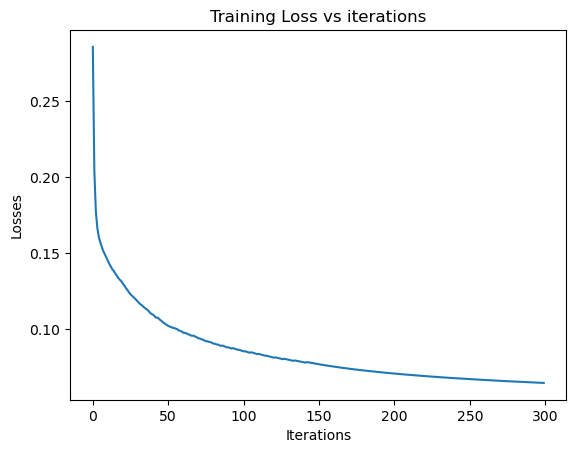

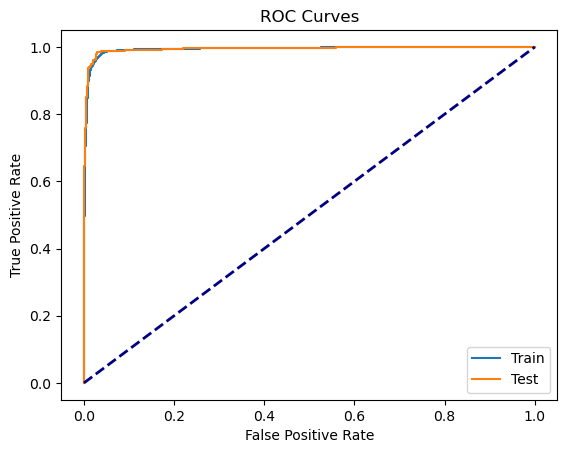

In [10]:
output = FSA(k = 100, X_train = X_traint, X_test = X_testt,eta = 0.01)
plt.plot(output[2])
plt.title('Training Loss vs iterations')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.show()
#For ROC Curves
score_train = output[3]
score_test = output[4]
fpr1, tpr1, thresholds1 = roc_curve(data_train_labels, score_train)
fpr2, tpr2, thresholds2 = roc_curve(data_test_labels, score_test)
plt.plot(fpr1, tpr1,label = 'Train')
plt.plot(fpr2, tpr2,label = 'Test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

,K-Values,Missclassification Error Train,Missclassification Error Test
0,10,10.033333,11.0
1,30,5.800000,6.7
2,100,3.116667,2.6
3,300,1.866667,1.6
4,500,1.633333,1.8


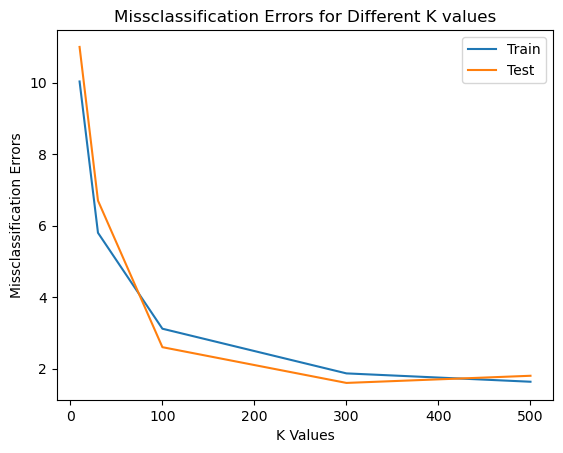

In [11]:
#Creating table

misscl_train = []
misscl_test = []

k = [10,30,100,300,500]

for val in k:
    outputs = FSA(k = val, X_train = X_traint, X_test = X_testt,eta = 0.01)
    miss_train = outputs[0]
    misscl_train.append(miss_train)
    miss_test = outputs[1]
    misscl_test.append(miss_test)
    
table = pd.DataFrame({'K-Values':k,'Missclassification Error Train' :misscl_train, 'Missclassification Error Test' : misscl_test})
plt.plot(k,misscl_train,label = 'Train')
plt.plot(k,misscl_test,label = 'Test')
plt.legend()
plt.xlabel('K Values')
plt.ylabel('Missclassification Errors')
plt.title('Missclassification Errors for Different K values')
table

### Question 1b: Dexter Dataset

In [12]:
data_train = pd.read_csv('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Dexter/dexter_train.csv',header = None)
data_train.shape
data_train_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Dexter/dexter_train.labels')
data_test = pd.read_csv('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Dexter/dexter_valid.csv',header = None)
data_test_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Dexter/dexter_valid.labels')
data_train.shape,data_train_labels.shape,data_test.shape,data_test_labels.shape

#Standardizing the training data
data_train = pd.DataFrame(data_train)
means = np.array(data_train.apply(lambda x : np.mean(x),axis = 0))
means = means.reshape(1,means.shape[0])
std_devs = np.array(data_train.apply(lambda x : np.std(x)))
std_devs = std_devs.reshape(1,std_devs.shape[0])
data_train = np.array(data_train)
data_train.shape
data_train = (data_train - means)/std_devs #final data

#standardizing the test data
data_test = pd.DataFrame(data_test)
#meanst = np.array(data_test.apply(lambda x : np.mean(x),axis = 0))
#meanst = meanst.reshape(1,meanst.shape[0])
#std_devst = np.array(data_test.apply(lambda x : np.std(x)))
#std_devst = std_devst.reshape(1,std_devst.shape[0])
data_test = np.array(data_test)
data_test.shape
data_test = (data_test - means)/std_devs   #final data
data_train.shape,data_test.shape

data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)
data_train_labels = pd.DataFrame(data_train_labels)
data_test_labels = pd.DataFrame(data_test_labels)

#Dropping the columns with NaN values
#For training data
cols1 = data_train.columns[data_train.isnull().any()].tolist()
print(len(cols1))
cols1

cols2 = data_test.columns[data_test.isnull().any()].tolist()
cols2
print(len(cols2))
#No Null columns for train and test
cols1 == cols2
#As the two columns have the same number of null values so we just go ahead and drop those

data_train = data_train.drop(cols1,axis = 1)
data_train.shape
np.where(data_train.isnull().any()) # No null values any more
print(data_train.shape)

data_test = data_test.drop(cols2,axis = 1)
print(data_test.shape)

#Checking whether any values are present any more
print(np.where(data_train.isnull().any()))
print(np.where(data_test.isnull().any()))
print(np.where(data_train_labels.isnull().any()))
print(np.where(data_test_labels.isnull().any())) 

X_train = np.array(data_train)
Y_labels_train = np.array(data_train_labels)
X_test = np.array(data_test)
Y_labels_test = np.array(data_test_labels)
X_train.shape,Y_labels_train.shape,X_test.shape,Y_labels_test.shape


X_ones_train =np.ones((X_train.shape[0], 1))
X_train = np.hstack((X_ones_train, X_train))
print(X_train.shape)

X_ones_test = np.ones((X_test.shape[0],1))
X_test = np.hstack((X_ones_test,X_test))
print(X_test.shape)

print(Y_labels_train.shape)
print(Y_labels_test.shape)

12249
12249
(300, 7751)
(300, 7751)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(300, 7752)
(300, 7752)
(300, 1)
(300, 1)


C:\Users\Sourita Nag\AppData\Local\Temp\ipykernel_21568\344839399.py:16: RuntimeWarning: invalid value encountered in divide
  data_train = (data_train - means)/std_devs #final data
C:\Users\Sourita Nag\AppData\Local\Temp\ipykernel_21568\344839399.py:26: RuntimeWarning: divide by zero encountered in divide
  data_test = (data_test - means)/std_devs   #final data
C:\Users\Sourita Nag\AppData\Local\Temp\ipykernel_21568\344839399.py:26: RuntimeWarning: invalid value encountered in divide
  data_test = (data_test - means)/std_devs   #final data


In [13]:
data_test_labels = np.array(data_test_labels)
data_train_labels = np.array(data_train_labels)

In [14]:
data_test_labels = data_test_labels.reshape(-1,1)
data_train_labels = data_train_labels.reshape(-1,1)
data_train_labels.shape,data_test_labels.shape

((300, 1), (300, 1))

In [15]:
X_traint = X_train
X_testt = X_test

In [16]:
#output = FSA(k = 10, X_train = X_traint, X_test = X_testt ,eta = 0.01)


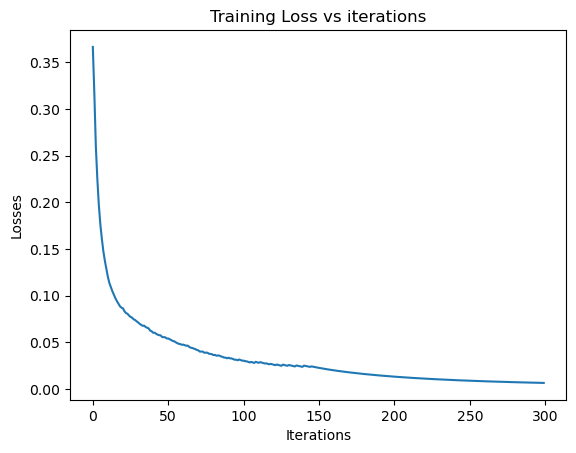

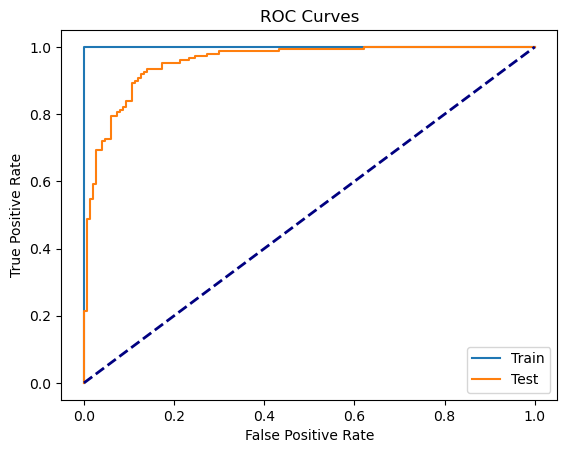

In [17]:
output = FSA(k = 100, X_train = X_traint, X_test = X_testt,eta = 0.01)
plt.plot(output[2])
plt.title('Training Loss vs iterations')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.show()
#For ROC Curves
score_train = output[3]
score_test = output[4]
fpr1, tpr1, thresholds1 = roc_curve(data_train_labels, score_train)
fpr2, tpr2, thresholds2 = roc_curve(data_test_labels, score_test)
plt.plot(fpr1, tpr1,label = 'Train')
plt.plot(fpr2, tpr2,label = 'Test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

,K-Values,Missclassification Error Train,Missclassification Error Test
0,10,10.000000,15.000000
1,30,3.666667,12.333333
2,100,0.000000,12.666667
3,300,0.000000,8.666667
4,500,0.000000,10.333333


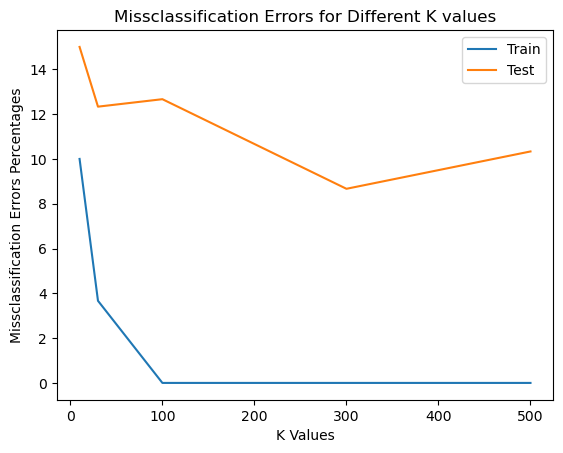

In [19]:
#Creating table

misscl_train = []
misscl_test = []

k = [10,30,100,300,500]

for val in k:
    outputs = FSA(k = val, X_train = X_traint, X_test = X_testt,eta = 0.01)
    miss_train = outputs[0]
    misscl_train.append(miss_train)
    miss_test = outputs[1]
    misscl_test.append(miss_test)
    
table = pd.DataFrame({'K-Values':k,'Missclassification Error Train' : misscl_train, 'Missclassification Error Test' : misscl_test})
plt.plot(k,misscl_train,label = 'Train')
plt.plot(k,misscl_test,label = 'Test')
plt.legend()
plt.xlabel('K Values')
plt.ylabel('Missclassification Errors Percentages')
plt.title('Missclassification Errors for Different K values')
table

### Question 1c: Madelon Dataset

In [21]:
data_train = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Madelon/madelon_train.data')
data_train
data_train_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Madelon/madelon_train.labels')
data_test = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Madelon/madelon_valid.data')
data_test_labels = np.loadtxt('C:/Users/Sourita Nag/OneDrive/Documents/Fourth Semester/Madelon/madelon_valid.labels')
data_train.shape,data_train_labels.shape,data_test.shape,data_test_labels.shape
#No Null data present at this stage


#Standardizing the training data
data_train = pd.DataFrame(data_train)
means = np.array(data_train.apply(lambda x : np.mean(x),axis = 0))
means = means.reshape(1,means.shape[0])
std_devs = np.array(data_train.apply(lambda x : np.std(x)))
std_devs = std_devs.reshape(1,std_devs.shape[0])
data_train = np.array(data_train)
data_train.shape
data_train = (data_train - means)/std_devs #final data

#standardizing the test data
data_test = pd.DataFrame(data_test)
#meanst = np.array(data_test.apply(lambda x : np.mean(x),axis = 0))
#meanst = meanst.reshape(1,meanst.shape[0])
#std_devst = np.array(data_test.apply(lambda x : np.std(x)))
#std_devst = std_devst.reshape(1,std_devst.shape[0])
data_test = np.array(data_test)
data_test.shape
data_test = (data_test - means)/std_devs   #final data
data_train.shape,data_test.shape

data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)
data_train_labels = pd.DataFrame(data_train_labels)
data_test_labels = pd.DataFrame(data_test_labels)

#Dropping the columns with NaN values
#For training data
cols1 = data_train.columns[data_train.isnull().any()].tolist()
print(len(cols1))
cols1

cols2 = data_test.columns[data_test.isnull().any()].tolist()
cols2
print(len(cols2))
#No Null columns for train and test

#Checking whether any values are present any more
print(np.where(data_train.isnull().any()))
print(np.where(data_test.isnull().any()))
print(np.where(data_train_labels.isnull().any()))
print(np.where(data_test_labels.isnull().any())) 

X_train = np.array(data_train)
Y_labels_train = np.array(data_train_labels)
X_test = np.array(data_test)
Y_labels_test = np.array(data_test_labels)
X_train.shape,Y_labels_train.shape,X_test.shape,Y_labels_test.shape

X_ones_train =np.ones((X_train.shape[0], 1))
X_train = np.hstack((X_ones_train, X_train))
print(X_train.shape)

X_ones_test = np.ones((X_test.shape[0],1))
X_test = np.hstack((X_ones_test,X_test))
print(X_test.shape)

print(Y_labels_train.shape)
print(Y_labels_test.shape)

0
0
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(2000, 501)
(600, 501)
(2000, 1)
(600, 1)


In [22]:
data_test_labels = np.array(data_test_labels)
data_train_labels = np.array(data_train_labels)

In [23]:
data_test_labels = data_test_labels.reshape(-1,1)
data_train_labels = data_train_labels.reshape(-1,1)
data_train_labels.shape,data_test_labels.shape

((2000, 1), (600, 1))

In [24]:
X_traint = X_train
X_testt = X_test

In [25]:
#output = FSA(k = 10, X_train = X_traint, X_test = X_testt,eta = 0.1 )


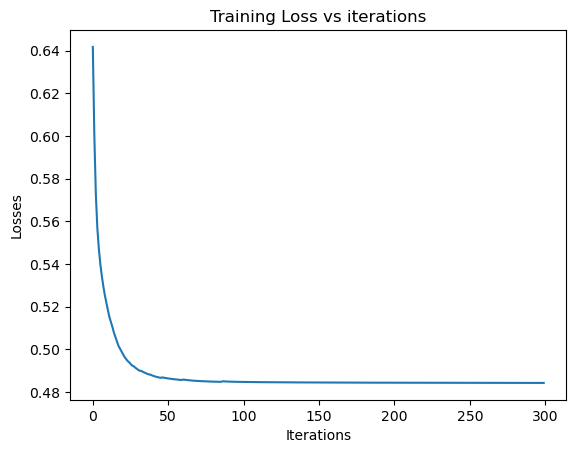

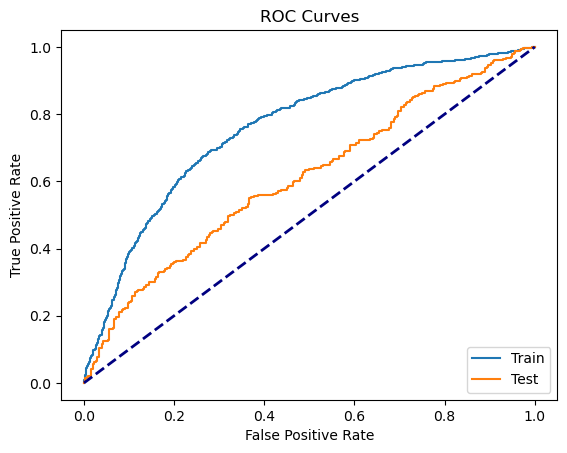

In [26]:
output = FSA(k = 100, X_train = X_traint, X_test = X_testt,eta = 0.1)
plt.plot(output[2])
plt.title('Training Loss vs iterations')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.show()
#For ROC Curves
score_train = output[3]
score_test = output[4]
fpr1, tpr1, thresholds1 = roc_curve(data_train_labels, score_train)
fpr2, tpr2, thresholds2 = roc_curve(data_test_labels, score_test)
plt.plot(fpr1, tpr1,label = 'Train')
plt.plot(fpr2, tpr2,label = 'Test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

,K-Values,Missclassification Error Train,Missclassification Error Test
0,10,36.90,40.000000
1,30,33.20,42.166667
2,100,30.15,41.333333
3,300,24.40,42.500000
4,500,20.00,42.166667


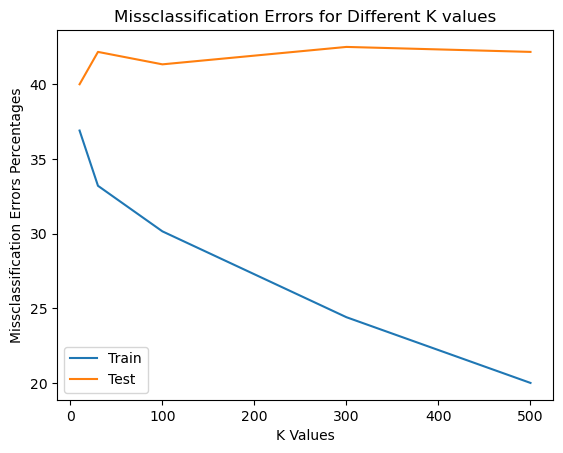

In [27]:
#Creating table

misscl_train = []
misscl_test = []

k = [10,30,100,300,500]

for val in k:
    outputs = FSA(k = val, X_train = X_traint, X_test = X_testt,eta = 0.1)
    miss_train = outputs[0]
    misscl_train.append(miss_train)
    miss_test = outputs[1]
    misscl_test.append(miss_test)
    
table = pd.DataFrame({'K-Values':k,'Missclassification Error Train' : misscl_train, 'Missclassification Error Test' : misscl_test})
plt.plot(k,misscl_train,label = 'Train')
plt.plot(k,misscl_test,label = 'Test')
plt.legend()
plt.xlabel('K Values')
plt.ylabel('Missclassification Errors Percentages')
plt.title('Missclassification Errors for Different K values')
table